In [448]:
import numpy as np
import pandas as pd
import json 
import multiprocessing as mp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import pickle
import re
tqdm.pandas()
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



c:\python\382\lib\site-packages\tqdm\std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
class Stats:
    def __init__(self,elapsed_time=0, items=0):
        self.elapsed_time = elapsed_time
        self.items= items
        
    def add(self,stats):
        self.elapsed_time += stats.elapsed_time
        self.items= +stats.items
        
    def to_string(self):
        return f'Elapsed time: {self.elapsed_time} - Items:{self.items}'
    
    def __str__(self):
        return self.to_string()
        
    def __repr__(self):
         return self.to_string()
            
    def __add__(self, o): 
        et = self.elapsed_time + o.elapsed_time
        it = self.items + o.items
        return Stats(et,it) 
    
    def __iadd__(self, o): 
        self.elapsed_time += o.elapsed_time
        self.items += o.items
        return self
    
        
def load_json_files(documents,directory_name):
    articles = {}
    
    articlenames = os.listdir(directory_name)
    pbar = tqdm(articlenames)
    pbar.set_description(f'Loading files from {directory_name}')
    for articlename in pbar:
        article_path = os.path.join(directory_name,articlename)
        if os.path.isdir(article_path):
            load_json_files(documents,article_path)
            continue
            
        filename = os.path.basename(articlename)
        filename = os.path.splitext(filename)[0]
        if filename not in documents:
            continue
            
        article = json.load(open(article_path, 'rb'))
        articles[filename] = article
        
    elapsed_time = pbar.format_dict['elapsed']
    items = pbar.format_dict['total']
    stats = Stats(elapsed_time,items)
    return stats, articles

def try_get_val(dictionary,dict_key):
    if dict_key in dictionary:
        return dictionary[dict_key]
    return None

def parse_collection(val):
    if val is not None:
        t_val = type(val)
        if t_val == tuple or  t_val == list:
            return ' '.join(val)
    return val

def load_json_article(article):
    paper_id = try_get_val(article,'paper_id')
    metadata = try_get_val(article,'metadata')
    title = try_get_val(article,'title')
    #source = article["source"]
    
    authors = []
    art_metadata = article['metadata']
    if 'authors' in art_metadata:
        for author in art_metadata['authors']:
            auth = {
            'paper_id' : paper_id,
            'full_name': '',
            'first' : author['first'],
            'middle': ' '.join(author['middle']),
            'last' : author['last'],
            'email' : author ['email'],
            'laboratory' : None,
            'institution' : None,
            'settlement' : None,
            'region' : None,
            'country' : None,
            'postCode' : None,
            }
            
            if 'affiliation' in author:
                afiliation = author['affiliation']
                auth['laboratory'] =  try_get_val(afiliation,'laboratory')
                auth['institution'] =  try_get_val(afiliation,'institution')
                if 'location' in  afiliation:
                    location = afiliation['location']
                    auth['settlement'] =  try_get_val(location,'settlement')
                    auth['region'] = try_get_val(location,'region')
                    auth['country'] = try_get_val(location,'country')
                    auth['postCode'] = try_get_val(location,'postCode')
            auth['full_name'] = auth['first'] + ' ' + auth['middle'] + ' ' + auth['last']
            
            authors.append(auth)

    body = []
    abstracts = []
    if 'body_text' in article:
        for bod in article["body_text"]:
            body.append(bod["text"])

    if 'abstract' in article:
        abstracts = [a['text'] for a in article["abstract"]]

    #"source" : source,
    art = {
        "paper_id" : paper_id,
        "title" : title,
        "abstract" : ' '.join(abstracts) ,
        "body" : ' '.join(body)
        
    }
    return art, authors 
    

def write_pickle(obj,file_name):
    file = open(file_name,'wb')
    pickle.dump(obj,file)
    file.close()
    
def read_pickle(file_name):
    obj = None
    if os.path.isfile(file_name):
        file = open(file_name,'rb')
        obj = pickle.load(file)
        file.close()
    return obj

In [5]:
path = '..\\CORD-19-research-challenge'
data_dirs = [
    'biorxiv_medrxiv\\biorxiv_medrxiv'
    ,'comm_use_subset\\comm_use_subset'
    ,'custom_license\\custom_license'
    ,'noncomm_use_subset\\noncomm_use_subset'
]
metadata_file = 'metadata.csv'

In [6]:
meta_df = pd.read_csv(os.path.join(path,metadata_file), dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

meta_df = meta_df[meta_df['sha'].notna()]

In [7]:
meta_df.describe()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
count,31753,31753,31753,31718,31445,16637,24743,31753,27916,31753,31198,30632,357,491,31753,31753,31750
unique,31752,31744,5,31479,31444,16637,24743,13,27832,5376,30310,4089,302,491,1,4,31749
top,c4u0gxp5,4644c32551fb23aa873a7738ecc8d777bd49877e,Elsevier,Commentary,10.1097/jcma.0000000000000270,PMC6710369,17706258,els-covid,Unknown,2016-12-31,"Domingo, Esteban",PLoS One,3006645647,#7235,True,custom_license,https://doi.org/10.1097/jcma.0000000000000270
freq,2,4,15517,6,2,1,1,15517,60,261,14,1561,9,1,31753,19816,2


In [8]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31753 entries, 0 to 45773
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     31753 non-null  object
 1   sha                          31753 non-null  object
 2   source_x                     31753 non-null  object
 3   title                        31718 non-null  object
 4   doi                          31445 non-null  object
 5   pmcid                        16637 non-null  object
 6   pubmed_id                    24743 non-null  object
 7   license                      31753 non-null  object
 8   abstract                     27916 non-null  object
 9   publish_time                 31753 non-null  object
 10  authors                      31198 non-null  object
 11  journal                      30632 non-null  object
 12  Microsoft Academic Paper ID  357 non-null    object
 13  WHO #Covidence               49

In [9]:
meta_df.drop_duplicates(['abstract','authors'], inplace=True)
meta_df['abstract'].describe(include='all')

count       27857
unique      27832
top       Unknown
freq           20
Name: abstract, dtype: object

In [10]:
meta_df.describe()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
count,31065,31065,31065,31063,30767,16548,24591,31065,27857,31065,30925,29945,351,483,31065,31065,31062
unique,31064,31057,5,30896,30766,16548,24591,13,27832,5356,30310,4035,297,483,1,4,31061
top,c4u0gxp5,4644c32551fb23aa873a7738ecc8d777bd49877e,PMC,Commentary,10.1097/jcma.0000000000000270,PMC6710369,17706258,els-covid,Unknown,2016-12-31,"Domingo, Esteban",PLoS One,3006645647,#7235,True,custom_license,https://doi.org/10.1097/jcma.0000000000000270
freq,2,4,14958,6,2,1,1,14904,20,244,14,1561,9,1,31065,19170,2


In [11]:
meta_df

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45767,b7e9grj0,889ba9338ea71cd42c3bc675db30a1928d487f43; d38e...,Elsevier,Relative immunogenicity and protection potenti...,10.1016/j.vaccine.2008.01.024,PMC2288748,18291562,els-covid,"Summary Yersinia Pestis outer proteins, plasmi...",2008-03-20,"Wang, Shixia; Joshi, Swati; Mboudjeka, Innocen...",Vaccine,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.vaccine.2008.01.024
45768,6b1y7yxg,f81692543d3e35858911cea48c298bfa23b20bc6,Elsevier,Quality of life and psychological status in su...,10.1016/j.jpsychores.2005.08.020,PMC7094294,16650592,els-covid,Abstract Background Little is known about the ...,2006-05-31,"Kwek, Seow-Khee; Chew, Wuen-Ming; Ong, Kian-Ch...",Journal of Psychosomatic Research,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.jpsychores.2005.08.020
45769,4360s2yu,289deae0b2050aa259a05ba84565a4df82fa099a,Elsevier,Personal Protective Equipment: Protecting Heal...,10.1016/j.clinthera.2015.07.007,PMC4661082,26452427,els-covid,Abstract Purpose The recent Ebola epidemic tha...,2015-11-01,"Fischer, William A.; Weber, David J.; Wohl, Da...",Clinical Therapeutics,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.clinthera.2015.07.007
45770,66jumbir,21a4369f83891bf6975dd916c0aa495d5df8709e,Elsevier,Viruses and asthma,10.1016/j.bbagen.2011.01.012,PMC3130828,21291960,els-covid,Abstract Background Viral respiratory infectio...,2011-11-30,"Dulek, Daniel E.; Peebles, R. Stokes",Biochimica et Biophysica Acta (BBA) - General ...,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.bbagen.2011.01.012


In [12]:
documents = meta_df.sha.to_list()
docs = []
for doc in documents:
    splits = doc.split(';')
    for split in splits:
        docs.append(split.strip())

In [13]:
pickle_file_name = 'json_data.pickle'
articles_set = read_pickle(pickle_file_name)
#articles_set = None
if articles_set is None:
    articles_set = {}
    stats = Stats()
    documents = meta_df.sha.to_list()
    for data_dir in data_dirs:
        st , articles = load_json_files(docs,os.path.join(path,data_dir))
        articles_set.update(articles) 
        stats += st
    print('Writing Pickle....')
    write_pickle(articles_set, pickle_file_name)


### Try read parquet data for processed articles and authors, if not available will re-run the parsing process

In [14]:
def try_read_parquet(file_name):
    if os.path.isfile(file_name):
        return pd.read_parquet(file_name)
    return None
    
authors_file = 'authors.parquet'
articles_file = 'articles.parquet'

authors = try_read_parquet(authors_file)
articles = try_read_parquet(articles_file)
if authors is None or articles is None:
    authors = pd.DataFrame()
    articles = pd.DataFrame()
    for key in tqdm(articles_set):
        article, auths = load_json_article(articles_set[key])
        articles = articles.append(article,ignore_index=True)
        authors= authors.append(pd.DataFrame(auths),ignore_index=True)
    authors.to_parquet(authors_file)
    articles.to_parquet(articles_file)
        
    

#### Now process the authors so we habe better insights where the paper publications are comming from

In [75]:
non_countries = {
    'alabama':'US',
    'belgique':'US',
    'brasil':'BR',
    'britis': 'GB',
    'bosnia':'BA',
    'britain':'GB',
    'california':'US',
    'cameroun':'CM',
    'carolina':'US',
    'czech':'CZ',
    'china':'CN',
    'england':'GB',
    'espagne':'ES',
    'f r g':'DE',
    'frg': 'DE',
    'german research':'DE',
    'hawaii':'US',
    'king saud':'SA',
    'korea':'KR',
    'ital':'IT',
    'iowa':'US',
    'espana':'ES',
    'iran':'IR',
    'iran article info':'IR',
    'iran iran':'IR',
    'kelantan':'MY',
    'ljsa':'GB',
    'macedonia':'MK',
    'maryland':'US',
    'missouri':'US',
    'nether':'NL',
    'oregon':'US',
    'palestine':'PS',
    'pennsylvania':'US',  
    'pereda':'ES',
    'pok':'PK',
    'prc':'CN',
    'roc': 'TW',
    'rsa': 'ZA',
    'reunion island':'FR',
    'syria':'SY',
    'scotland':'GB',
    'slovak': 'SK',
    'south dustralia':'AU',
    'tehran iran':'IR',
    'tunis':'TN',
    'tx':'US',
    'u k':'GB',
    'u s a':'US',
    'uae':'AE',
    'uk':'GB',
    'ulsan':'KR',
    'united':'US',
    'united  states':'US',
    'united arab':'AE',
    'united arab uae':'AE',
    'unites states':'US',
    'universitd debordeaux il':'FR',
    'ucblecnrs':'FR',
    'usa':'US',
    'us':'US',
    'ussr':'RU',
    'umr':'US', #University of Minnesota
    'ut':'US',
    'utah':'US',
    'wales uk':'GB',
    'wpg uk': 'GB',
    'xinjiang uyghur':'CN',
    'aland islands':'FI'}

In [186]:
import pycountry as pc
countries  = list(pc.countries) # Get list of oficcial countries
countries_dict = {c.alpha_2: c.common_name if hasattr(c,'common_name') else c.name for c in pc.countries }
def  parse_countries(country, official_ctries,non_countries):
    if country != None :
        country = country.strip().lower()
        country = pc.remove_accents(country) # Remove accesnts by finding the closest ASCII equivalent
        country = re.sub(r'[0-9]+|\.|;|\(|\)|\+|\?|,', '', country)
        country = re.sub(r'\s\s+', ' ', country)
        for cty in non_countries:
            if cty in country:
                a2 = non_countries[cty]
                a3 = pc.countries.get(alpha_2=a2).alpha_3
                return (a2,a3)
        for oc in official_ctries:
            oc_name = oc.name.lower()
            oc_common_name = oc_name
            if hasattr(oc,'common_name'):
                oc_common_name =  oc.common_name.lower()
            #country = country.capitalize().replace('.','')
            if oc.name in country or \
                oc_common_name in country:
                return (oc.alpha_2, oc.alpha_3)
    return (country,None)

In [190]:
authors_papers = authors[['paper_id','full_name']]
authors_unique = authors.drop(columns=['paper_id'])
authors_unique =  authors_unique.drop_duplicates()
unique_countries = authors_unique.country.unique()

unique_countries_dict = {x:parse_countries(x,countries,non_countries) for x in unique_countries }
authors_unique['country_code_alpha2'] = authors_unique.country.progress_apply(lambda x: unique_countries_dict[x][0] if x != None else 'Unknown' )
authors_unique['country_code_alpha3'] = authors_unique.country.progress_apply(lambda x: unique_countries_dict[x][1] if x != None else 'Unknown' )
authors_unique['country'] = authors_unique['country_code_alpha2'].progress_apply(lambda x: countries_dict[x] if x in countries_dict  else x)
unique_countries = authors_unique.country.unique()
unique_countries.sort()

In [259]:
by_country = authors_unique[['country','country_code_alpha3','country_code_alpha2','full_name']].groupby(['country','country_code_alpha3','country_code_alpha2'])
by_country = by_country.count().reset_index()
bc = by_country.sort_values('full_name', ascending=False)
bc=bc.rename(columns={'full_name':'total_publications'})
total_publications = bc.total_publications.sum()
bc = bc[ (bc.country != 'Unknown')]
pubs_by_country = bc.total_publications.sum()

In [229]:
import plotly.express as px
fig = px.scatter_geo(bc,title=f"Overview of total number of papers issued by country ({pubs_by_country} from {total_publications})", 
                     locations="country_code_alpha3", color="country", hover_name="country", size="total_publications",projection="natural earth")
fig.show()

### Now Process the whole article set

In [440]:
articles = try_read_parquet(articles_file)

In [441]:
articles.drop(columns=['title'],inplace=True)
articles.drop_duplicates(['abstract', 'body'], inplace=True)
articles.dropna(inplace=True)

In [442]:
articles.describe()

,abstract,body,paper_id
count,33030,33030,33030
unique,24400,33011,33030
top,,"Dipeptidyl peptidase 4 (DPP4, CD26), a type II...",e7e0c619c9f078101beffb8b3822c65e95995856
freq,8474,2,1


Removing punctuation marks and setting word counts and lower case letters

In [443]:
articles['abstract_word_count'] = articles['abstract'].progress_apply(lambda x: len(x.strip().split()))
articles['body_word_count'] = articles['body'].progress_apply(lambda x: len(x.strip().split()))
articles['body'] = articles['body'].progress_apply(lambda x: re.sub('[^a-zA-z\s]','',x.lower()))
articles['abstract'] = articles['abstract'].progress_apply(lambda x: re.sub('[^a-zA-z\s]','',x.lower())) # Originally included numbers 0-9
articles = articles[articles['body_word_count'] > 100] # Remove articles with low body text content

Several articles do not contain an abstract, therefore the language translation will be based on the body contents

#### Trying clustering classification by abstract

First will try to identify the language in which each article was written

In [444]:
%pip install nltk
%pip install langdetect

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [445]:
import nltk
import langdetect
def detect_language(text):
    try:
        return langdetect.detect(text)
    except:
        return 'Unknown'
    
articles['language'] = articles['body'].progress_apply(lambda x:detect_language(x))
articles[articles.language == "Unknown"]

,abstract,body,paper_id,abstract_word_count,body_word_count,language
27668,postexposure prophylaxis pep has substantially...,human immunodeficiency virus hiv testing pract...,d67de3269f28e5be514f0e91e18305f653672256,14,3453,Unknown


There are some documents without proper or inconsistent body , probably wrongly parsed from the web portal, even th word counts are low

In [454]:
articles = articles[articles['language']!='Unknown']

In [455]:
ag = articles.groupby('language')
ag.count()

,abstract,body,paper_id,abstract_word_count,body_word_count
language,,,,,
da,1,1,1,1,1
de,64,64,64,64,64
en,32128,32128,32128,32128,32128
es,279,279,279,279,279
fr,313,313,313,313,313
it,15,15,15,15,15
pl,2,2,2,2,2
pt,8,8,8,8,8
ro,1,1,1,1,1


After analyzing the results it is foreseable that the document corpora contains papers in different languages, from which three of them are not identifiable due to wrong encoding or failure on the pdf data during the import process.
Ininteligible languages are:
- af
- ca
- cy

Therefore will be discarded

In [456]:
articles[articles.language =='af'].body

Series([], Name: body, dtype: object)

In [457]:
discard_languages = ['af','ca','cy']
articles = articles[~articles.language.isin( discard_languages)]
ag = articles.groupby('language')
ag= ag.count()
ag.sort_values(by='body',ascending=False)

,abstract,body,paper_id,abstract_word_count,body_word_count
language,,,,,
en,32128,32128,32128,32128,32128
fr,313,313,313,313,313
es,279,279,279,279,279
de,64,64,64,64,64
it,15,15,15,15,15
pt,8,8,8,8,8
pl,2,2,2,2,2
da,1,1,1,1,1
ro,1,1,1,1,1


In [458]:
list(ag.index)

['da', 'de', 'en', 'es', 'fr', 'it', 'pl', 'pt', 'ro', 'sv']

<BarContainer object of 10 artists>

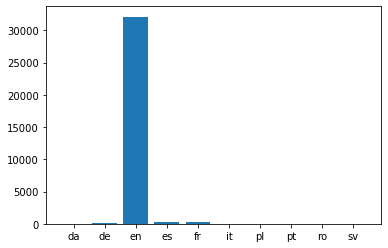

In [459]:
plt.bar(x=list(ag.index), height=ag.body)

Spicy Library will be used for text classification

In [460]:
%pip install spicy

Note: you may need to restart the kernel to use updated packages.


In [461]:
!python -m spacy download en_core_web_lg

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


Focus only on english text since is the majority and the one that will bring more context to the classification

In [462]:
articles = articles[articles.language=='en']

In [463]:
import spacy
nlp = spacy.load('en_core_web_sm')
punctuations = spacy.lang.punctuation.PUNCT
stopwords = spacy.lang.en.stop_words.STOP_WORDS
def cleanup(doc):
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [token.lemma_.lower().strip() for token in doc if token.lemma_ != '-PRON-']
    tokens = [token for token in tokens if token not in stopwords and token not in punctuations]
    tokens = ' '.join(tokens)
    texts = tokens
    return texts

In [ ]:
articles['body_parsed'] = articles['body'].progress_apply(lambda x: cleanup(x))

In [ ]:
articles['body_parsed_word_count'] = articles['body_parsed'].progress_apply(lambda x: len(x.strip().split()))

In [ ]:
INFO_text = [text for text in train[train['Conference'] == 'INFOCOM']['Title']]
IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]
INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()
IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()
INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)
INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the research papers for conference INFOCOM')
plt.show()